**BigMart Sales Prediction practice problem**

We have train (8523) and test (5681) data set, train data set has both input and output variable(s). We need to predict the sales for test data set.


* Item_Identifier: Unique product ID

* Item_Weight: Weight of product

* Item_Fat_Content: Whether the product is low fat or not

* Item_Visibility: The % of total display area of all products in a store allocated to the particular product

* Item_Type: The category to which the product belongs

* Item_MRP: Maximum Retail Price (list price) of the product

* Outlet_Identifier: Unique store ID

* Outlet_Establishment_Year: The year in which store was established

* Outlet_Size: The size of the store in terms of ground area covered

* Outlet_Location_Type: The type of city in which the store is located

* Outlet_Type: Whether the outlet is just a grocery store or some sort of supermarket

* Item_Outlet_Sales: Sales of the product in the particulat store. This is the outcome variable to be predicted.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load Libraries**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

**Data Mining**

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Train (1).csv')
test = pd.read_csv('/content/drive/MyDrive/Test (1).csv')

**Exploratory Data Analysis**

In [ ]:
train.shape, test.shape

((8523, 12), (5681, 11))

In [ ]:
train.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [ ]:
test.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

Using the above test data, we must forecast Item Outlet Sales.

To begin Exploratory Data Analysis, let's combine the train and test data.


In [ ]:
train['source'] = 'train'
test['source'] = 'test'
test['Item_Outlet_Sales'] = 0
data = pd.concat([train, test], sort = False)
print(train.shape, test.shape, data.shape)

(8523, 13) (5681, 13) (14204, 13)


In [ ]:
data['Item_Outlet_Sales'].describe()

count    14204.000000
mean      1308.865489
std       1699.791423
min          0.000000
25%          0.000000
50%        559.272000
75%       2163.184200
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

<ipython-input-11-e2b58dbb7453>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Item_Outlet_Sales'])


<Axes: xlabel='Item_Outlet_Sales', ylabel='Density'>

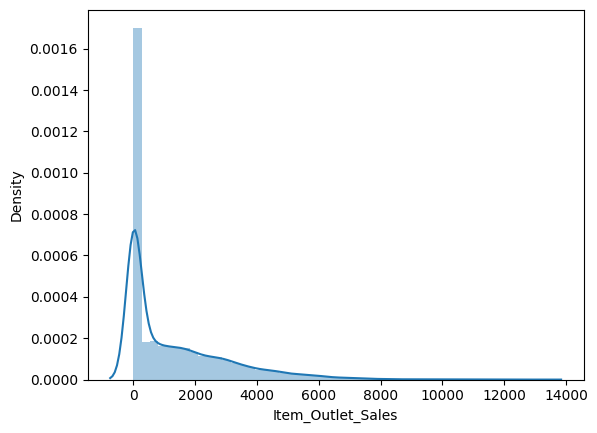

In [ ]:
sns.distplot(data['Item_Outlet_Sales'])

1. Deviate from the normal distribution.
1. Have appreciable positive skewness.
1. Show peakedness. **bold text**

In [ ]:
print('Skewness: %f' % data['Item_Outlet_Sales'].skew())
print('Kurtsis: %f' %data['Item_Outlet_Sales'].kurt())

Skewness: 1.544684
Kurtsis: 2.419439


Let's examine categorical and numerical variables.

In [ ]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
source                        object
dtype: object

In [ ]:
categorial_features = data.select_dtypes(include=[np.object])
categorial_features.head(2)

<ipython-input-14-fdb6849c7bdc>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorial_features = data.select_dtypes(include=[np.object])


,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,source
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1,train
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2,train


In [ ]:
numerical_features = data.select_dtypes(include=[np.number])
numerical_features.head(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.30,0.016047,249.8092,1999,3735.1380
1,5.92,0.019278,48.2692,2009,443.4228


In [ ]:
data['Outlet_Establishment_Year'].value_counts()

1985    2439
1987    1553
1999    1550
1997    1550
2004    1550
2002    1548
2009    1546
2007    1543
1998     925
Name: Outlet_Establishment_Year, dtype: int64

**Finding Missing values**

In [ ]:
data.apply(lambda x: sum(x.isnull()))

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
source                          0
dtype: int64

**Some observations:**

*  **Item_Visibility** has a minimum value of. This is absurd from a practical standpoint since a product cannot be sold at a store with a visibility of 0.

* **Outlet_Establishment_Years** differ from 1985 and 2009. In this form, the values might not be appropriate. It should have a stronger effect on sales if we can translate them to the age of the specific shop.

* The lower ‘count’ of **Item_Weight** and **Outlet_Size** confirms the findings from the missing value check.

In [ ]:
data.apply(lambda x : len(x.unique()))

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
source                           2
dtype: int64

This informs us that there are 10 outlets/stores and 1559 goods (which was also mentioned in problem statement). The fact that Item Type has 16 distinct values should also be noted. Let's investigate further utilising each nominal variable's frequency of various categories.

In [ ]:
#frequency of categories
for col in categorial_features:
    print('\n%s column: '%col)
    print(data[col].value_counts())


Item_Identifier column: 
FDU15    10
FDS25    10
FDA38    10
FDW03    10
FDJ10    10
         ..
FDR51     7
FDM52     7
DRN11     7
FDH58     7
NCW54     7
Name: Item_Identifier, Length: 1559, dtype: int64

Item_Fat_Content column: 
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Item_Type column: 
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Outlet_Identifier column: 
OUT027    1559
OUT013    1553
OUT049    1550
OUT046    1550
OUT035    1550
OUT045    1548


**Lets start looking Outlet_Size, Outlet_Location_Type, and	Outlet_Type distribution in Item_Outlet_Sale**

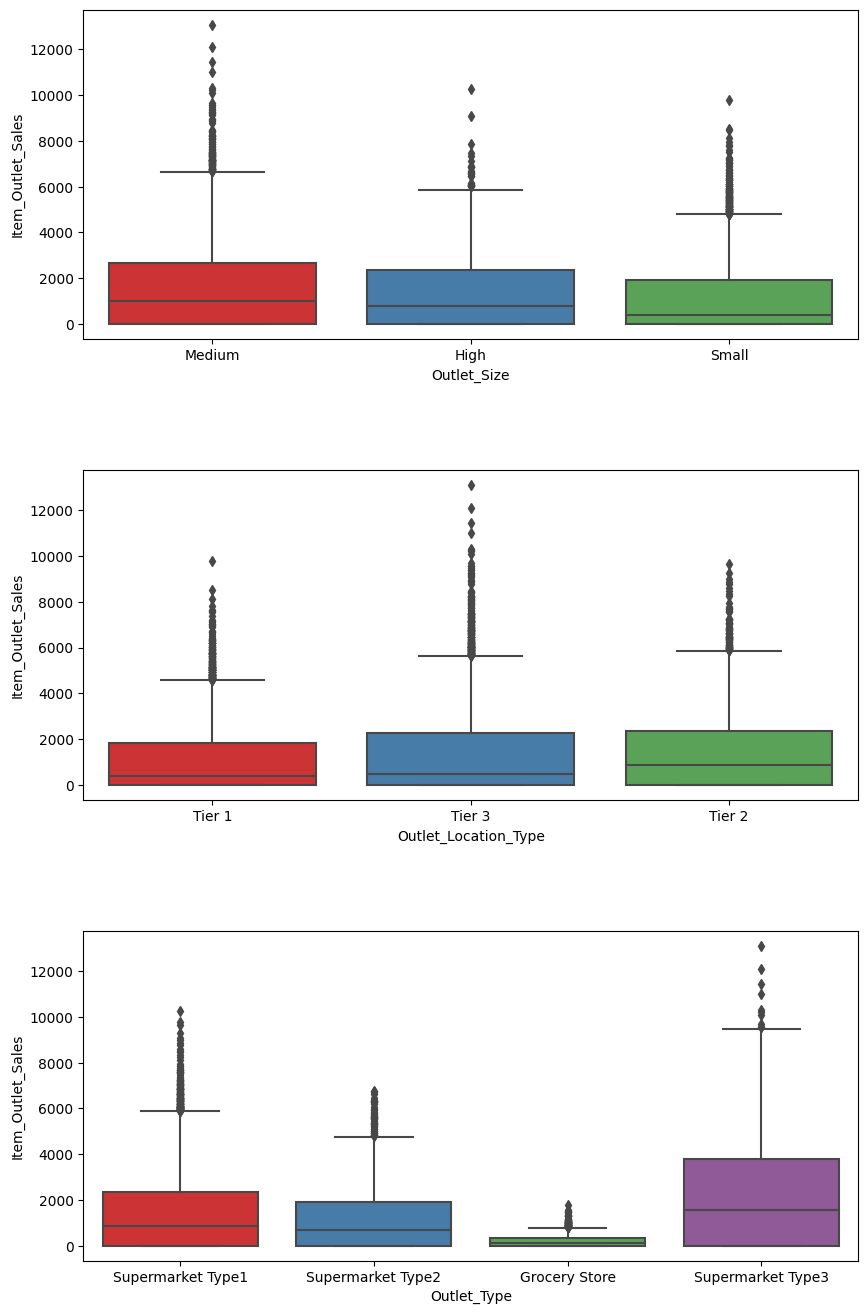

In [ ]:
plt.figure(figsize = (10,9))

plt.subplot(311)
sns.boxplot(x='Outlet_Size', y='Item_Outlet_Sales', data=data, palette="Set1")

plt.subplot(312)
sns.boxplot(x='Outlet_Location_Type', y='Item_Outlet_Sales', data=data, palette="Set1")

plt.subplot(313)
sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data=data, palette="Set1")

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 1.5)

plt.show()

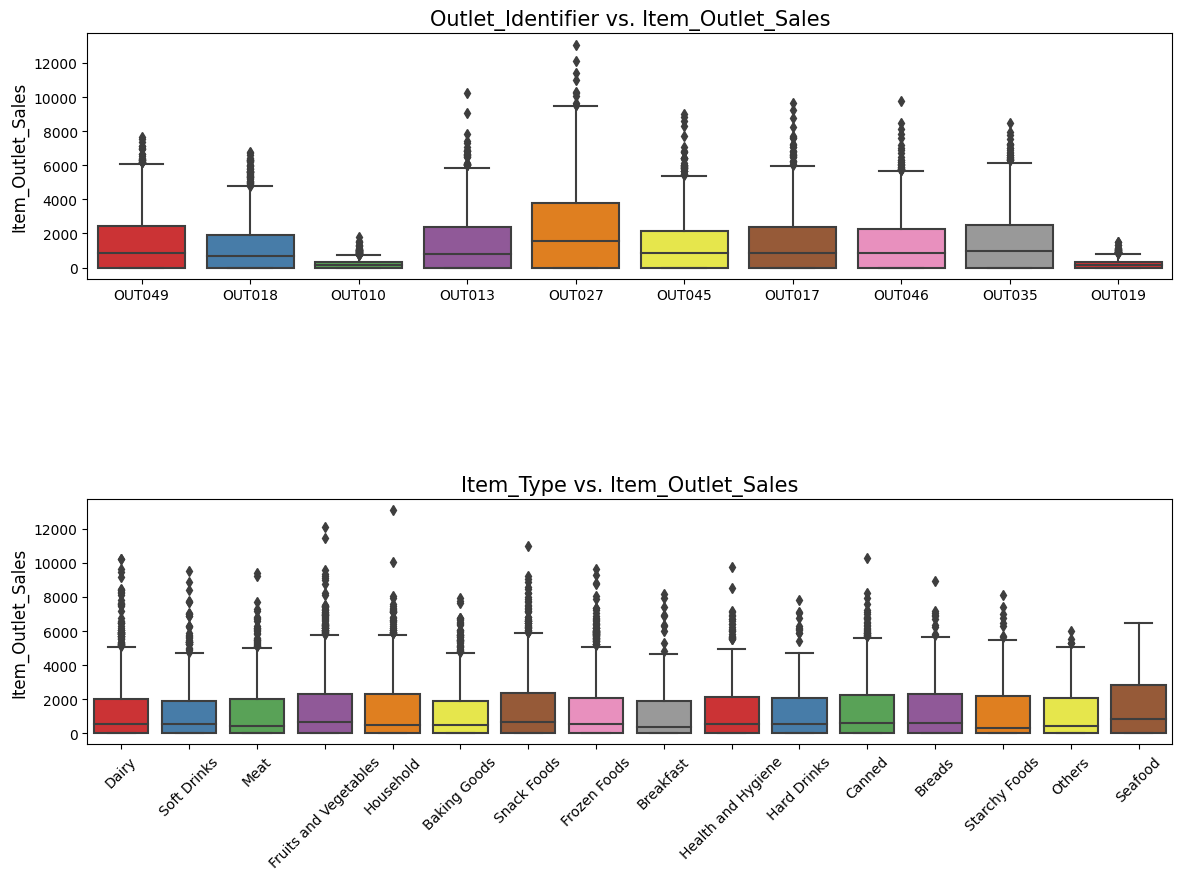

In [ ]:
plt.figure(figsize = (14,9))

plt.subplot(211)
ax = sns.boxplot(x='Outlet_Identifier', y='Item_Outlet_Sales', data=data, palette="Set1")
ax.set_title("Outlet_Identifier vs. Item_Outlet_Sales", fontsize=15)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Item_Outlet_Sales", fontsize=12)

plt.subplot(212)
ax = sns.boxplot(x='Item_Type', y='Item_Outlet_Sales', data=data, palette="Set1")
ax.set_title("Item_Type vs. Item_Outlet_Sales", fontsize=15)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Item_Outlet_Sales", fontsize=12)

plt.subplots_adjust(hspace = 0.9, top = 0.9)
plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()



**Data Cleaning and Imputing Missing Values**

Item Weight and Outlet Size are two variables that we discovered to be lacking values. Let's assume the former based on the typical weight of the specific item. You might do this by:

In [ ]:
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')

missing_values = data['Item_Weight'].isnull()
print('Missing values: %d' %sum(missing_values))

data.loc[missing_values,'Item_Weight']  = data.loc[missing_values,'Item_Identifier'].apply(lambda x: item_avg_weight.at[x,'Item_Weight'])
print('Missing values after immputation %d' %sum(data['Item_Weight'].isnull()))

Missing values: 2439
Missing values after immputation 0


This demonstrates that the column no longer contains any missing data. Let's compute Outlet Size using the Outlet Size's mode for the specific type of outlet.

In [ ]:
#Import mode function:
from scipy.stats import mode

#Determing the mode for each
outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x.astype('str')).mode[0]))
print ('Mode for each Outlet_Type:')
print (outlet_size_mode)

#Get a boolean variable specifying missing Item_Weight values
missing_values = data['Outlet_Size'].isnull()

#Impute data and check #missing values before and after imputation to confirm
print ('\nOrignal #missing: %d'% sum(missing_values))
data.loc[missing_values,'Outlet_Size'] = data.loc[missing_values,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
print (sum(data['Outlet_Size'].isnull()))

Mode for each Outlet_Type:
Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size           nan             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  

Orignal #missing: 4016
0


<ipython-input-23-ac1f70b21854>:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x.astype('str')).mode[0]))


**Modify Item_Visibility**

We noticed that the minimum value here is 0, which makes no practical sense. Lets consider it like missing information and impute it with mean visibility of that product.

In [ ]:
#Determine average visibility of a product
visibility_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')

#Impute 0 values with mean visibility of that product:
missing_values = (data['Item_Visibility'] == 0)

print ('Number of 0 values initially: %d'%sum(missing_values))
data.loc[missing_values,'Item_Visibility'] = data.loc[missing_values,'Item_Identifier'].apply(lambda x: visibility_avg.at[x, 'Item_Visibility'])
print ('Number of 0 values after modification: %d'%sum(data['Item_Visibility'] == 0))

Number of 0 values initially: 879
Number of 0 values after modification: 0


**Create a broad category of Type of Item**

Earlier we saw that the Item_Type variable has 16 categories which might prove to be very useful in analysis. So its a good idea to combine them. One way could be to manually assign a new category to each. But there’s a catch here. If you look at the Item_Identifier, i.e. the unique ID of each item, it starts with either FD, DR or NC. If you see the categories, these look like being Food, Drinks and Non-Consumables. So I’ve used the Item_Identifier variable to create a new column:

In [ ]:
#Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

**Modify categories of Item_Fat_Content**

We found typos and difference in representation in categories of Item_Fat_Content variable. This can be corrected as:

In [ ]:
#Change categories of low fat:
print('Original Categories:')
print(data['Item_Fat_Content'].value_counts())

print('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print(data['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


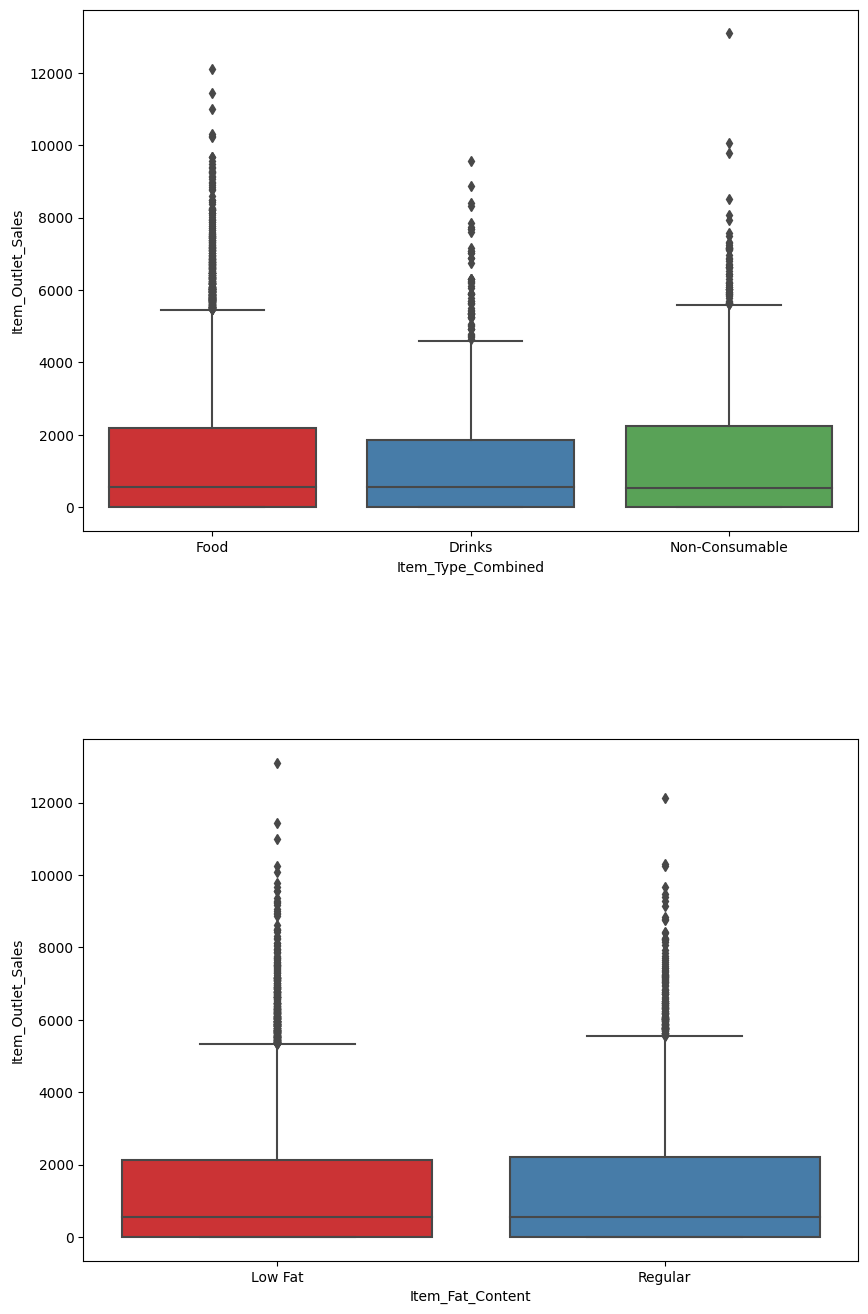

In [ ]:
plt.figure(figsize = (10,9))

plt.subplot(211)
sns.boxplot(x='Item_Type_Combined', y='Item_Outlet_Sales', data=data, palette="Set1")

plt.subplot(212)
sns.boxplot(x='Item_Fat_Content', y='Item_Outlet_Sales', data=data, palette="Set1")

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 1.5)

plt.show()

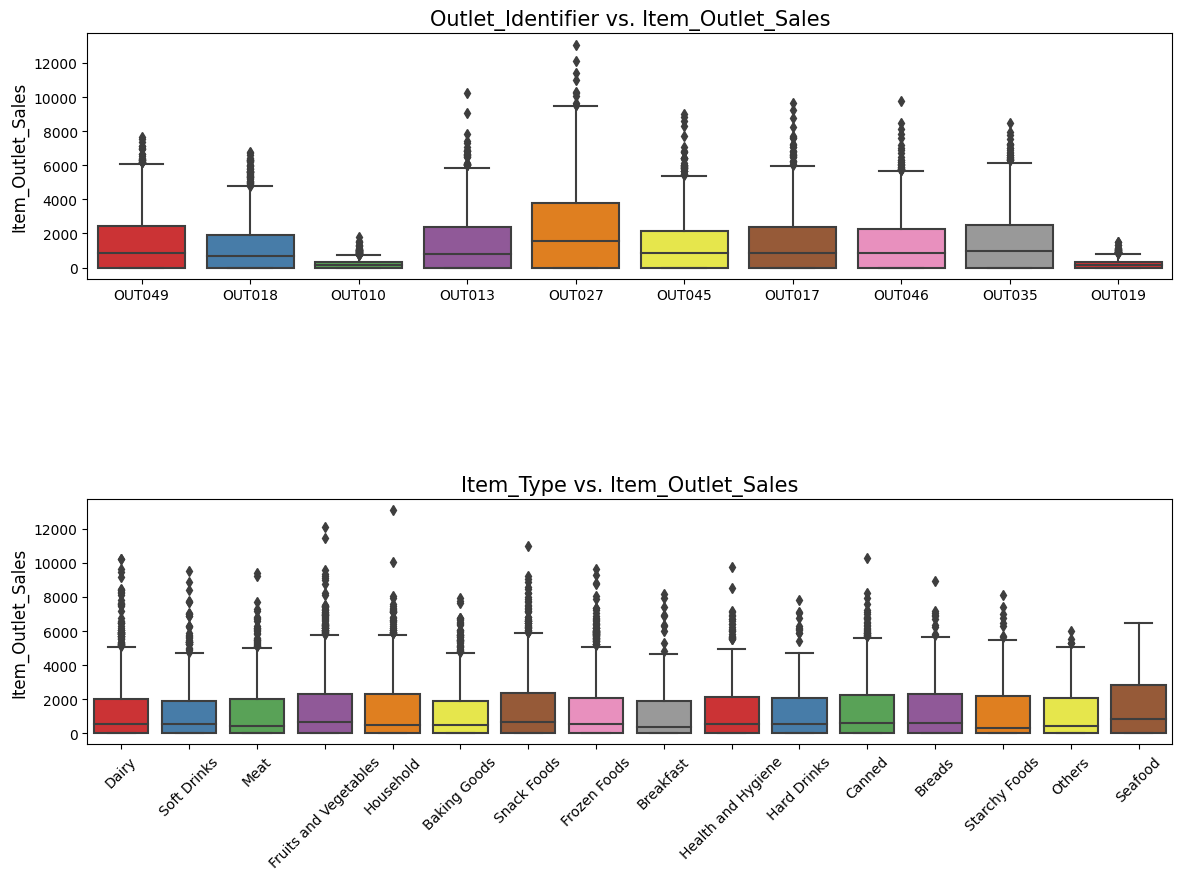

In [ ]:
plt.figure(figsize = (14,9))

plt.subplot(211)
ax = sns.boxplot(x='Outlet_Identifier', y='Item_Outlet_Sales', data=data, palette="Set1")
ax.set_title("Outlet_Identifier vs. Item_Outlet_Sales", fontsize=15)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Item_Outlet_Sales", fontsize=12)

plt.subplot(212)
ax = sns.boxplot(x='Item_Type', y='Item_Outlet_Sales', data=data, palette="Set1")
ax.set_title("Item_Type vs. Item_Outlet_Sales", fontsize=15)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Item_Outlet_Sales", fontsize=12)

plt.subplots_adjust(hspace = 0.9, top = 0.9)
plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()

In [ ]:
data.index = data['Outlet_Establishment_Year']
data.index

Int64Index([1999, 2009, 1999, 1998, 1987, 2009, 1987, 1985, 2002, 2007,
            ...
            1999, 1999, 2009, 1997, 1999, 1997, 2009, 2002, 2007, 2002],
           dtype='int64', name='Outlet_Establishment_Year', length=14204)

In [ ]:
df = data.loc[:,['Item_Outlet_Sales']]
df.head(2)

,Item_Outlet_Sales
Outlet_Establishment_Year,
1999,3735.1380
2009,443.4228


**Determine the years of operation of a store**
We wanted to make a new column depicting the years of operation of a store. This can be done as:

In [ ]:
data['Outlet_Years'] = 2009 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        11.169319
std          8.371664
min          0.000000
25%          5.000000
50%         10.000000
75%         22.000000
max         24.000000
Name: Outlet_Years, dtype: float64

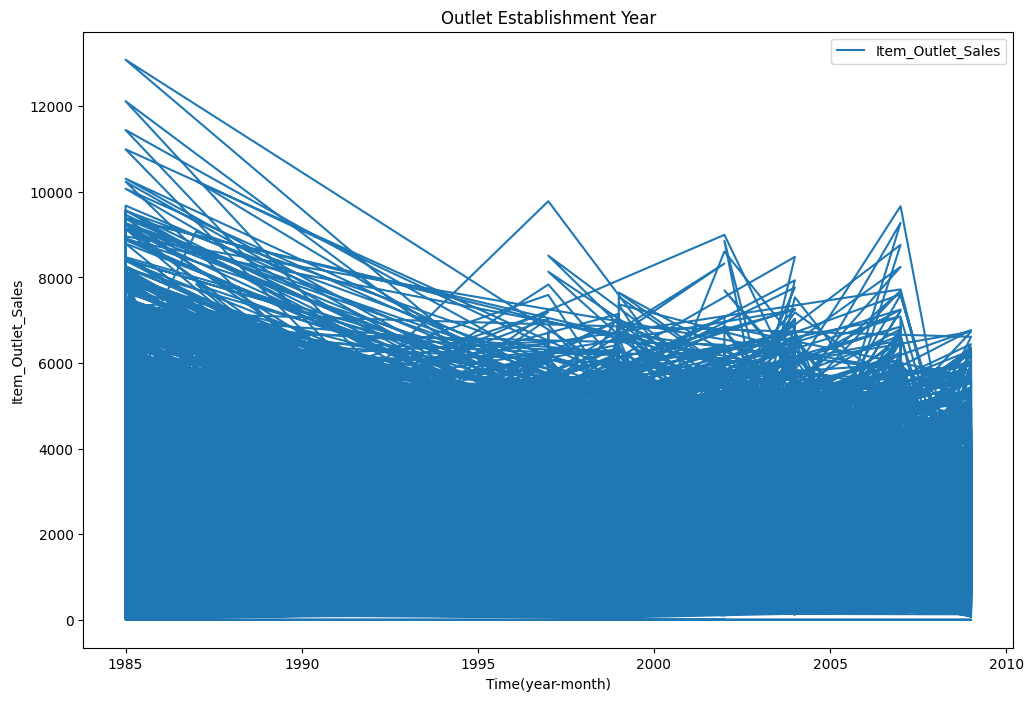

In [ ]:
data.index = data['Outlet_Establishment_Year']
df = data.loc[:,['Item_Outlet_Sales']]
ts = df['Item_Outlet_Sales']
plt.figure(figsize=(12,8))
plt.plot(ts, label='Item_Outlet_Sales')
plt.title('Outlet Establishment Year')
plt.xlabel('Time(year-month)')
plt.ylabel('Item_Outlet_Sales')
plt.legend(loc = 'best')
plt.show()

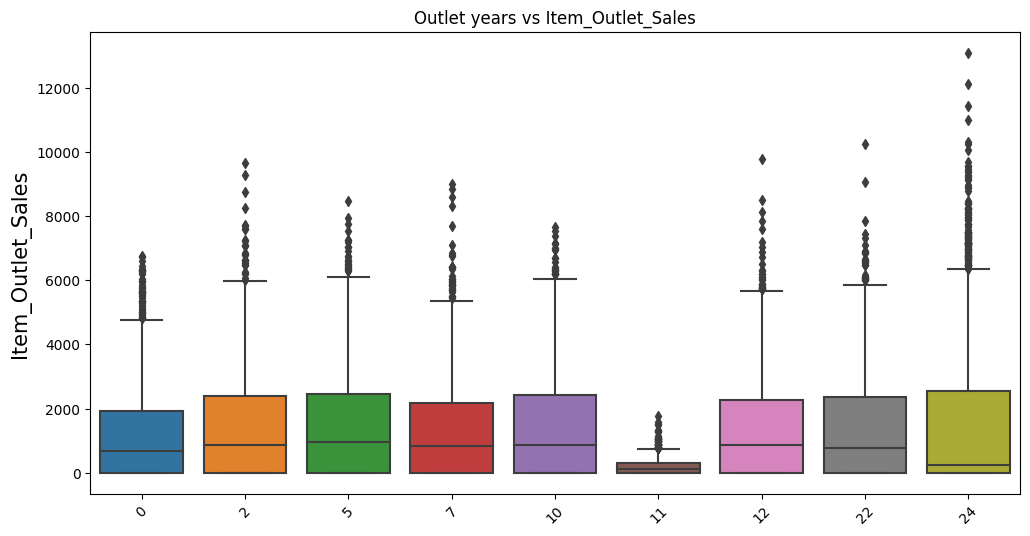

In [ ]:
plt.figure(figsize = (12,6))
ax = sns.boxplot(x = 'Outlet_Years', y = 'Item_Outlet_Sales', data = data)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
ax.set_title('Outlet years vs Item_Outlet_Sales')
ax.set_xlabel('', fontsize = 15)
ax.set_ylabel('Item_Outlet_Sales', fontsize = 15)

plt.show()

In [ ]:
temp_data = data.loc[data['Outlet_Establishment_Year'] == 1998]

In [ ]:
temp_data['Outlet_Type'].value_counts()

Grocery Store    925
Name: Outlet_Type, dtype: int64

Based on the observation from 1998 data, we can see there is only Grocery Store Type as Outlet_Type
thus Item_Outlet_Sale is minimum.

Thought to remove those data as part of data cleaning for more accurate model, however we need to check first it's posibilities in test data as well.

In [ ]:
test_temp_data = test.loc[test['Outlet_Establishment_Year'] == 1998]
test_temp_data['Outlet_Type'].value_counts()

Grocery Store    370
Name: Outlet_Type, dtype: int64

Which shows resonably very low data however we can not remove it. so lets keep it as it is.

**Numerical and One-Hot Coding of Categorical variables**

In [ ]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [ ]:
#One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

In [ ]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
source                        object
Outlet_Years                   int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Size_3                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
Outlet_0                       uint8
O

In [ ]:
#Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

<ipython-input-40-c662200c9945>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
<ipython-input-40-c662200c9945>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['source'],axis=1,inplace=True)


data is ready for model building